<a href="https://colab.research.google.com/github/eisbetterthanpi/pytorch/blob/main/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## top

In [ ]:
# @title data
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 4 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.20MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.9MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.82MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# @title torchvision resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
# model = get_res(256).to(device)
# print(model)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [ ]:
# @title autoencoder
import torch
import torch.nn as nn

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.encoder = torch.nn.Sequential(
        #     nn.Linear(28 * 28, 512), nn.ReLU(),
        #     nn.Linear(512, 128), nn.ReLU(),
        #     nn.Linear(128, 64), nn.ReLU(),
        #     nn.Linear(64, 32),  nn.ReLU(), # 32>10 to account for variation of members within the same class
        # )

        self.encoder = nn.Sequential( # 28 # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.Conv2d(1, 16, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 14
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 7
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 3
            nn.Conv2d(32, 32, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2), # 1
            # nn.Conv2d(32, 32, 3, stride=1, padding=1), # 1
            # nn.Conv2d(16, 8, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(start_dim=1),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (32,1,1)),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=0), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0, output_padding=0), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        # self.decoder = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
        #     nn.Upsample((3,3)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample((7,7)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample(scale_factor=2), nn.ConvTranspose2d(32, 16, 3, 1, padding=1), nn.ReLU(),
        #     nn.Upsample(scale_factor=2), nn.ConvTranspose2d(16, 1, 3, 1, padding=1), nn.Sigmoid()
        # )

        # self.decoder = torch.nn.Sequential(
        #     nn.Linear(32, 64), nn.ReLU(),
        #     nn.Linear(64, 128), nn.ReLU(),
        #     nn.Linear(128, 512), nn.ReLU(),
        #     nn.Linear(512, 28 * 28), nn.ReLU(),
        # )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)
print(sum(p.numel() for p in model.encoder.parameters() if p.requires_grad))
print(sum(p.numel() for p in model.decoder.parameters() if p.requires_grad))

# 477920
# 23296, 23265

input = torch.rand((4,1,28,28), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



23296
23265
torch.Size([4, 32])
torch.Size([4, 1, 28, 28])


In [ ]:
# @title train
loss_function = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr = 1e-1, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-8)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-3


def train(model, train_loader, loss_function, optimizer):
    outputs = []
    losses = []
    model.train()
    for image, _ in train_loader:
        image = image.to(device)#.reshape(-1, 28*28)
        reconstructed = model(image)
        loss = loss_function(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu())
        try: wandb.log({"loss": loss.item()})
        except: pass
    # scheduler.step()
    lr=optimizer.param_groups[0]["lr"]
    # print(lr)
    print("loss: ",sum(losses[-batch_size:]).item()/batch_size)
    outputs.append((epochs, image, reconstructed))

# loss:  0.013260149396955967
# loss:  0.010282933712005615
# loss:  0.009744454175233841
# loss:  0.008946227841079235
# loss:  0.006832938175648451
# loss:  0.007862974889576435
# loss:  0.0076667130924761295
# loss:  0.005621504969894886
# loss:  0.009382324293255806
# loss:  0.007828746922314167

epochs = 10
for epoch in range(epochs):
    train(model, train_loader, loss_function, optimizer)
    encoded = model.encode(item[0].unsqueeze(0).to(device))
    print("encoded: ",encoded)
    reconstructed = model.decode(encoded.unsqueeze(0))

    print("reconstructed:")
    # reconstructed = reconstructed.reshape(-1, 28, 28)
    # reconstructed = reconstructed.unsqueeze(0)
    plt.imshow(reconstructed.detach().cpu().squeeze())
    plt.show()


loss:  0.008434731513261795


NameError: name 'item' is not defined

original:


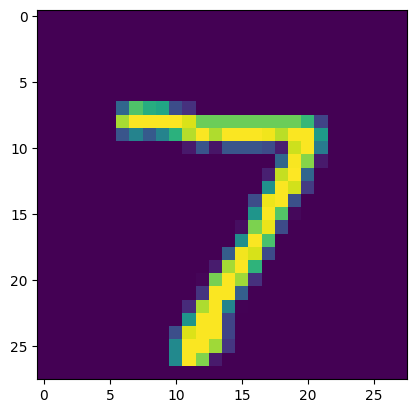

torch.Size([1, 1, 28, 28])
encoded:  torch.Size([1, 64, 7, 7])
reconstructed:


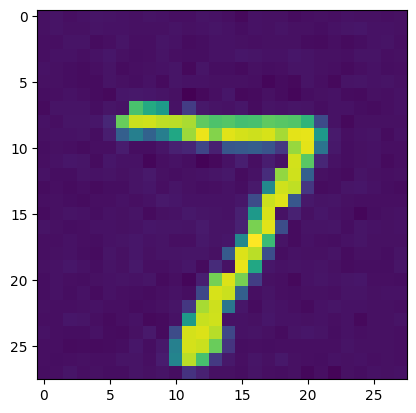

In [ ]:
# @title evaluate

dataiter = iter(test_data)
item, labels = next(dataiter) # images, labels
print("original:")
plt.imshow(item.cpu()[0])
plt.show()

model.eval()
encoded = model.encode(item.unsqueeze(0).to(device))
# print("encoded: ",encoded.shape)
reconstructed = model.decode(encoded)

print("reconstructed:")
plt.imshow(reconstructed.detach().cpu().squeeze())
plt.show()


In [ ]:

name='agent_convt.pth'
# name='agent_upsample.pth'
folder = '/content/'
torch.save(model.state_dict(), folder+name)
# model.load_state_dict(torch.load(folder+name), strict=False)


In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="conv_ae", config={"model": "res18",})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

# torch.save(model.state_dict(), folder+name)
# model.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
# torch.save(model.state_dict(), '/content/'+name)
# model.load_state_dict(torch.load('/content/'+name, map_location=device), strict=False)

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer_rand512.pkl', 'wb') as f: pickle.dump((buffer), f)
# with open(folder+'buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)
with open(folder+'buffer512.pkl', 'rb') as f: buffer = pickle.load(f)
# https://drive.google.com/file/d/1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY/view?usp=drive_link


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## now

In [1]:
# @title gdown
import pickle
!gdown 1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY -O buffer512.pkl # S
with open('buffer512.pkl', 'rb') as f: buffer = pickle.load(f)

Downloading...
From (original): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY
From (redirected): https://drive.google.com/uc?id=1fYC7rJswDFpLeyywD56bu9ZjCQEyzRvY&confirm=t&uuid=f813beb9-71a0-4c00-b789-357482caded8
To: /content/buffer512.pkl
100% 706M/706M [00:08<00:00, 85.3MB/s]


In [2]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward = self.data[idx]
        state = self.transform(state)
        return state

    def add(self, episode):
        self.data.append(episode)

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 128 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    # model = models.resnet101(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    # model.layer3 = nn.Sequential()
    # model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

model = get_res(256).to(device)
# print(model)
input = torch.rand((16,3,64,64),device=device)
# input = torch.rand(16,1,256,256)
out = model(input)
print(out.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683

# res18/34 11,176,512/21,284,672 lyr4 64,64->512
# res18/34 2,782,784/ 8,170,304 nolyr4 64,64->256
# res18/34 683,072/ 1,347,904 nolyr34 64,64->128
# res50 lyr4 23508032 64,64->2048
# res50 nolyr4 8543296 64,64->1024
# res50 nolyr34 1444928 64,64->512


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


torch.Size([16, 512])
11176512


In [ ]:
# @title conv deconv
import torch
import torch.nn as nn


class Deconv(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        # d_model = 32
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            # nn.ConvTranspose2d(d_model, d_model, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            # nn.ConvTranspose2d(d_model, 3, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
            nn.ConvTranspose2d(d_model, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        self.decoder = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            # nn.Upsample((7,7)), nn.ConvTranspose2d(32, 32, 3, 1, padding=1), nn.ReLU(),
            # nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, d_model, 3, 1, padding=1), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_model, 3, 3, 1, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.decoder(x.unsqueeze(-1).unsqueeze(-1))
        return x


device = "cuda" if torch.cuda.is_available() else "cpu"

conv = Deconv(512).to(device)
print(sum(p.numel() for p in conv.parameters() if p.requires_grad)) # 19683
input = torch.rand((4,512), device=device)
out = conv(input)
print(out.shape)


11812867
torch.Size([4, 3, 64, 64])


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # d_list=[32, 64, 128, 256, 512, 1024]
        # d_list=[32, 64, 128, 256, 512, 256]
        d_list=[32, 64, 128, 256, 256, 256]
        # d_list=[128, 256, 512, 1024]
        # d_list=[64, 128, 256, 512, 1024, 2048]
        # r_list=[(360,640), (240,426), (144,256)] # https://en.wikipedia.org/wiki/Low-definition_television
        self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), nn.MaxPool2d(kernel_size=2, stride=2), # SiLU ReLU
            # nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.ReLU(), nn.MaxPool2d(2, 2),

            # good
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(), #nn.Dropout(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),


            # nn.Conv2d(3, d_list[0], 7, 1, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[0], d_list[1], 5, 1, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[1], d_list[2], 3, 1, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[2], d_list[3], 3, 1, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[3], d_list[3], 3, 1, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[3], d_list[3], 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),

            # nn.Conv2d(3, d_list[0], 7, 1, 3), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[0], d_list[1], 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[1], d_list[2], 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[2], d_list[3], 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[3], d_list[3], 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            # nn.Conv2d(d_list[3], d_list[3], 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),

            # nn.AdaptiveMaxPool2d(1), # AdaptiveAvgPool2d AdaptiveMaxPool2d
            nn.Flatten(start_dim=1),
            nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
        )

        self.deconv = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[5], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1), nn.Sigmoid(),

            nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # good
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),


            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[3], 3, 1, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[3], 3, 1, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[2], 3, 1, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 1, 1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 1, 2), nn.BatchNorm2d(d_list[0]), nn.ReLU(),

            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[3], 3, 1, 1), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[3], 3, 1, 1), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[3], d_list[2], 3, 1, 1), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 1, 1), nn.ReLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 1, 2), nn.ReLU(),

            # nn.Upsample((16,16))
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[0], 3, 7, 1, 3), nn.Sigmoid(),
        )

    def forward(self, x):
        # print("fwd1",x.shape)
        x = self.encode(x)
        # print("fwd2",x.shape)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x)#.squeeze()
    def decode(self, x):
        # return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
        # x= self.deconv(x.unsqueeze(-1).unsqueeze(-1))
        x= self.deconv(x)
        # x = x / 2 + 0.5  # unnormalize
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
# model = autoencoder(256).to(device)
# model = autoencoder(1024).to(device)
model = autoencoder().to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



1278976
1278979
torch.Size([4, 256])
torch.Size([4, 3, 64, 64])


In [ ]:
# @title lin autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_list=[32, 64, 128, 256, 512, 1024]
        # d_list=[32, 64, 128, 256, 256, 256]
        self.enc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(64*64*3,d_list[5]), nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.Linear(d_list[5],64*64*3),
            nn.Unflatten(-1, (3,64,64)),
        )

    def forward(self, x):
        # print("fwd1",x.shape)
        x = self.encode(x)
        # print("fwd2",x.shape)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x)#.squeeze()
    def decode(self, x):
        x= self.deconv(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
# model = autoencoder(256).to(device)
# model = autoencoder(1024).to(device)
model = autoencoder().to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



12583936
12595200
torch.Size([4, 1024])
torch.Size([4, 3, 64, 64])


In [ ]:
# @title autoencoder dreamer

# https://github.com/abhayraw1/planet-torch/blob/master/rssm_model.py
# https://github.com/cross32768/PlaNet_PyTorch/blob/master/model.py
# https://github.com/abhayraw1/planet-torch/blob/master/rssm_model.py
# https://github.com/NM512/dreamerv3-torch/blob/main/networks.py#L448


class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        d_list=[32, 64, 128, 1024]
        self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), nn.MaxPool2d(kernel_size=2, stride=2), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 4, 2, 0), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[0], d_list[1], 4, 2), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[1], d_list[2], 4, 2), nn.ReLU(), #nn.Dropout(),
            nn.Conv2d(d_list[2], d_list[3], 4, 2), nn.ReLU(), #nn.Dropout(),
            # nn.AdaptiveMaxPool2d(1), # AdaptiveAvgPool2d AdaptiveMaxPool2d
            nn.Flatten(start_dim=1),
            nn.Linear(4*1024,1024), nn.ReLU(),
        )

        self.deconv = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
            # nn.Upsample(scale_factor=2),
            nn.Linear(1024,4*1024), nn.ReLU(), #nn.Dropout(),
            nn.Unflatten(-1, (1024,2,2)),
            nn.ConvTranspose2d(d_list[3], d_list[2], 5, 2, 1, output_padding=1), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 5, 2, 1, output_padding=1), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 6, 2, 1, output_padding=1), nn.ReLU(), #nn.Dropout(),
            nn.ConvTranspose2d(d_list[0], 3, 6, 2, 1, output_padding=0),# nn.Sigmoid(),

        )

    def forward(self, x):
        # print("fwd1",x.shape)
        x = self.encode(x)
        # print("fwd2",x.shape)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x)#.squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
# model = autoencoder(256).to(device)
# model = autoencoder(1024).to(device)
model = autoencoder().to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



6459104
7757411
torch.Size([4, 1024])
torch.Size([4, 3, 64, 64])


In [ ]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    # def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
    def __init__(self, d_model, dim_v):
        super(JEPA, self).__init__()
        # d_list=[32, 64, 128, 256, 512, 1024]
        d_list=[32, 64, d_model]
        self.enc = nn.Sequential(
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1), nn.Flatten(start_dim=1),
        )
        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1), nn.Sigmoid(),
        )
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        # self.dim_z = dim_z
        # self.sim_coeff=10.0 # 25.0 # λ
        self.std_coeff=10.0 # 25.0 # µ
        self.cov_coeff=1.0 # 1.0 # ν
        # self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        # return std_loss, cov_loss

    # def argm(self, sx, a, sy):
    #     batch=sx.size(dim=0)
    #     z = nn.Parameter(torch.rand((batch,self.dim_z),device=device)*2 -1)#*self.dim_z**(-0.5) # 1/d^(1/2)
    #     optim = torch.optim.SGD([z], lr=3e3)
    #     lossfn = torch.nn.MSELoss()
    #     sx, a, sy = sx.detach(), a.detach(), sy.detach()
    #     num_steps = 10
    #     for i in range(num_steps):
    #         sxaz = torch.cat([sx, a, z], dim=-1)
    #         sy_ = self.pred(sxaz)
    #         # print("y_, y",y_.shape, y.shape)
    #         loss = lossfn(sy_, sy)
    #         loss.backward()
    #         optim.step()
    #         optim.zero_grad()
    #     if loss.item()>0.1: print("argm",loss.item(), z[0].item())
    #     return z#.detach()

    def loss(self, x):
        sx = self.enc(x)
        std_loss, cov_loss = self.v_creg(self.exp(sx))
        dec_loss = F.mse_loss(self.decode(sx.detach()), x)
        return std_loss, cov_loss, dec_loss

    def forward(self, x):
        # print("fwd1", x.shape)
        x = self.encode(x)
        # print("fwd2", x.shape)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x)#.squeeze()
    def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    # def decode(self, x): return self.deconv(x)


d_model=128 # 128
dim_v=32
model = JEPA(d_model, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# loss = model.loss(x,y)


In [ ]:
# @title test balls bins
out_ch=3
balls=6

# dim_scales = [int(out_ch / (2 ** i)) for i in range(1, balls)] # [64, 32]
# dim_scales = [round(out_ch / (2 ** i)) for i in range(1, balls)] # [64, 32]
# dim_scales = [round((balls-out_ch) / (2.5 ** i))+1 for i in range(1, out_ch)] # [64, 32]
# dim_scales = [*dim_scales, out_ch - sum(dim_scales)] # [64, 32, 32] # more channels for smaller kernels

mult = [1/(1.4**i) for i in range(out_ch)]
mul = balls/sum(mult)
mult = [m*mul for m in mult]
# print(mult)
print([floor(m) for m in mult])
dim_scales = [0]*out_ch
# for i in range(balls):
#     ind = mult.index(max(mult))
#     dim_scales[ind] += 1
#     mult[ind] -= 1

# r=2
# dim_scales = [int((out_ch/r**2) / (2 ** i)) for i in range(1, len(kernel_sizes))] # [64, 32]
# dim_scales = [*dim_scales, int(out_ch/r**2) - sum(dim_scales)] # [64, 32, 32]
# dim_scales = [d*r**2 for d in dim_scales]
print('dim_scales',dim_scales)


In [3]:
# @title mha me
import torch
import torch.nn as nn

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        # self.lin = nn.Linear(d_model, d_model)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.lin(out) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V


class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head, cond_dim=None, ff_dim=None, dropout=0.):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.ReLU()
        if ff_dim==None: ff_dim=d_model*4
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), # ReLU GELU
            nn.RMSNorm(ff_dim), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), act, nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Linear(ff_dim, d_model)
            # nn.RMSNorm(d_model), nn.Linear(d_model, ff_dim), nn.ReLU(), nn.Dropout(dropout), # ReLU GELU
            # nn.Linear(ff_dim, d_model), nn.Dropout(dropout),
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        bchw = x.shape
        x = x.flatten(2).transpose(1,2) # [b,h*w,c]
        # if self.cond_dim==None: cond=None # is self attn
        x = x + self.self(self.norm1(x))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        return x.transpose(1,2).reshape(*bchw)



# d_model=8
# d_head=4
# batch=4
# h,w=5,6
# x=torch.rand(batch,d_model,h,w)
# cond_dim=10
# model = AttentionBlock(d_model=d_model, d_head=d_head,cond_dim=cond_dim)
# num_tok=1
# cond=torch.rand(batch,num_tok,cond_dim)
# mask=torch.rand(batch,h*w)>0.5
# out = model(x, cond, mask)
# print(out.shape)
# # print(out)


In [48]:
# @title PixelShuffleConv
import torch
from torch import nn
from torch.nn import functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CrossEmbedLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_sizes, stride=1):
        super().__init__()
        kernel_sizes = sorted(kernel_sizes)

        r=2
        balls = out_ch//r**2
        mult = [1/(1.6**i) for i in range(len(kernel_sizes))]
        mul = balls/sum(mult)
        mult = [m*mul for m in mult]
        dim_scales = [0]*len(kernel_sizes)
        for i in range(balls):
            ind = mult.index(max(mult))
            dim_scales[ind] += 1
            mult[ind] -= 1
        dim_scales = [d*r**2 for d in dim_scales]
        if 0 in dim_scales: print('dim_scales',dim_scales)
        # 1/2 + 1/4 + 1/8 + ... + 1/2^num_kernels + 1/2^num_kernels of out_ch; smaller kernel allocated more channels
        self.convs = nn.ModuleList([nn.Conv2d(in_ch, dim_scale, kernel, stride=stride, padding=(kernel-stride)//2) for kernel, dim_scale in zip(kernel_sizes, dim_scales)])

    def forward(self, x):
        # return torch.cat([conv(x) for conv in self.convs], dim = 1)
        out = torch.cat([conv(x) for conv in self.convs], dim = 1)
        b,c,h,w = out.shape
        out = out.reshape(b, -1, 4, h, w).transpose(1,2).reshape(b, c, h, w)
        return out

class PixelShuffleConv(nn.Module):
    def __init__(self, in_ch, out_ch = None, kernel_size=3, r=2):
        super().__init__()
        if out_ch==None: out_ch = in_ch
        self.in_ch, self.out_ch, self.r = in_ch, out_ch, r
        r = max(r, int(1/r))
        if self.r>1: self.net = nn.Sequential(nn.Conv2d(in_ch, out_ch * r**2, kernel_size, 1, padding=kernel_size//2), nn.PixelShuffle(r)) # PixelShuffle: [b,c*r^2,h,w] -> [b,c,h*r,w*r] # upscale by upscale factor r # https://arxiv.org/pdf/1609.05158v2
        elif self.r<1: self.net = nn.Sequential(nn.PixelUnshuffle(r), nn.Conv2d(in_ch * r**2, out_ch, kernel_size, 1, padding=kernel_size//2)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]
        else: self.net = nn.Conv2d(in_ch, out_ch, kernel_size, 1, padding=kernel_size//2)
        self.net.apply(self.init_conv_)

    def init_conv_(self, conv): # weight initialisation very important for the performance of pixelshuffle!
        if isinstance(conv, nn.Conv2d):
            o, i, h, w = conv.weight.shape
            conv_weight = torch.empty(self.out_ch, self.in_ch, h, w)
            nn.init.kaiming_uniform_(conv_weight)
            # print(conv.weight.shape, conv_weight.shape,max(self.r, int(1/self.r)), (0 if self.r>1 else 1))
            conv.weight.data.copy_(conv_weight.repeat_interleave(max(self.r, int(1/self.r))**2, dim=(0 if self.r>1 else 1)))
            nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)


In [49]:
# @title unet me
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# torch.set_default_dtype(torch.float16)

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, emb=None, cond=None):
        for layer in self:
            args = [x]
            if 'emb' in layer._fwdparams: args.append(emb)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch=None, emb_dim=None, drop=0.):
        super().__init__()
        if out_ch==None: out_ch=in_ch
        act = nn.SiLU() #
        self.block1 = nn.Sequential(nn.BatchNorm2d(in_ch), act, nn.Conv2d(in_ch, out_ch, 3, padding=1))
        self.block2 = Seq(nn.BatchNorm2d(out_ch), scale_shift(out_ch, emb_dim) if emb_dim != None else nn.Identity(), act, nn.Conv2d(out_ch, out_ch, 3, padding=1))
        # self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
        self.res_conv = zero_module(nn.Conv2d(in_ch, out_ch, 1)) if in_ch != out_ch else nn.Identity()

    def forward(self, x, emb=None): # [b,c,h,w], [batch, emb_dim]
        h = self.block1(x)
        h = self.block2(h, emb)
        return h + self.res_conv(x)

        # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, d_list[0], 7, 1, padding=7//2), in_r=2), act, # good
        init_conv(nn.Conv2d(d_list[1], d_list[0] * 2**2, 5, 1, padding=5//2), out_r=2), nn.PixelShuffle(2), act, # good


class scale_shift(nn.Module): # FiLM
    def __init__(self, x_dim, t_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_dim, x_dim*2),)

    def forward(self, x, emb): # [b,c,h,w], [b,emb_dim]
        scale, shift = self.time_mlp(emb)[..., None, None].chunk(2, dim=1) # [b,t_dim]->[b,2*x_dim,1,1]->[b,x_dim,1,1]
        return x * (scale + 1) + shift

class levelBlock(nn.Module):
    def __init__(self, in_ch, out_ch, emb_dim=None, cond_dim=None, n_head=None, d_head=8, updown=False, r=2):
        super().__init__()
        if updown=='down': in_ch = in_ch*r**2
        elif updown=='up': out_ch = out_ch*r**2
        # if n_head==None: n_head = out_ch // d_head
        # self.op = nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1) # optional # stride = 2 if conv_dim != 3 else (1, 2, 2) # If 3D, then downsampling occurs in the inner-two dimensions
        # self.op = nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1), act)
        # # self.op = avg_pool_nd(conv_dim, kernel_size=stride, stride=stride) # alternative
    # return nn.Sequential(nn.PixelUnshuffle(2), nn.Conv2d(in_ch * 4, out_ch, 1)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]

        layers = [
            nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
            ResBlock(in_ch, out_ch, emb_dim=emb_dim),
            AttentionBlock(out_ch, d_head, cond_dim),
            nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
            ]

        # layers = [
        #     PixelShuffleConv(in_ch, out_ch, kernel_size=1, r=1/2) if updown=='down' else nn.Identity(),
        #     ResBlock(out_ch if updown=='down' else in_ch, emb_dim=emb_dim),
        #     AttentionBlock(out_ch if updown=='down' else in_ch, d_head, cond_dim),
        #     PixelShuffleConv(in_ch, out_ch, kernel_size=1, r=2) if updown=='up' else nn.Identity(),
        #     ]

        # x = F.interpolate(x, scale_factor=2, mode="nearest") # if self.conv_dim == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        # return nn.Sequential(nn.Interpolate(scale_factor = 2, mode = 'nearest'), nn.Conv2d(in_ch, out_ch, 3, padding=1))

        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)



class levelBlock(nn.Module):
    def __init__(self, in_ch, d_model, out_ch, emb_dim=None, cond_dim=None, n_head=None, d_head=8, updown=False, r=1):
        super().__init__()
        # if n_head==None: n_head = out_ch // d_head
    # return nn.Sequential(nn.PixelUnshuffle(2), nn.Conv2d(in_ch * 4, out_ch, 1)) # PixelUnshuffle: [b,c,h*r,w*r] -> [b,c*r^2,h,w]

        # layers = [
        #     nn.PixelUnshuffle(r) if updown=='down' else nn.Identity(),
        #     ResBlock(in_ch, out_ch, emb_dim=emb_dim),
        #     AttentionBlock(out_ch, d_head, cond_dim),
        #     nn.PixelShuffle(r) if updown=='up' else nn.Identity(),
        #     ]

        layers = [
            # PixelShuffleConv(in_ch, d_model, kernel_size=1, r=1/2) if updown=='down' else nn.Identity(),
            # PixelShuffleConv(in_ch, d_model, kernel_size=1, r=1/2 if updown=='down' else 1) if in_ch != d_model else nn.Identity(),
            PixelShuffleConv(in_ch, d_model, kernel_size=1, r=r) if in_ch != d_model else nn.Identity(),
            ResBlock(d_model, emb_dim=emb_dim),
            AttentionBlock(d_model, d_head, cond_dim),
            # PixelShuffleConv(d_model, out_ch, kernel_size=1, r=2) if updown=='up' else nn.Identity(),
            # PixelShuffleConv(d_model, out_ch, kernel_size=1, r=2 if updown=='up' else 1) if out_ch != d_model else nn.Identity(),
            PixelShuffleConv(d_model, out_ch, kernel_size=1, r=r) if out_ch != d_model else nn.Identity(),
            ]

        # x = F.interpolate(x, scale_factor=2, mode="nearest") # if self.conv_dim == 3: x = F.interpolate(x, (x.shape[2], x.shape[3] * 2, x.shape[4] * 2), mode="nearest")
        # return nn.Sequential(nn.Interpolate(scale_factor = 2, mode = 'nearest'), nn.Conv2d(in_ch, out_ch, 3, padding=1))

        self.seq = Seq(*layers)

    def forward(self, x, emb=None, cond=None):
        return self.seq(x, emb, cond)


class UNet(nn.Module):
    def __init__(self, in_ch=3, d_model=16, out_ch=None, cond_dim=16, depth=4, num_res_blocks=1, n_head=-1, d_head=4):
        super().__init__()
        self.in_ch = in_ch
        self.d_model = d_model # base channel count for the model
        out_ch = out_ch or in_ch
        n_head = d_model // d_head

        self.rotemb = RotEmb(d_model)
        emb_dim = d_model# * 4
        self.time_emb = nn.Sequential(nn.Linear(d_model, emb_dim), nn.SiLU(), nn.Linear(emb_dim, emb_dim))

        self.in_block = nn.Sequential(nn.Conv2d(in_ch, d_model, 3, padding=1))
        # self.init_conv = CrossEmbedLayer(in_ch, dim_out=d_model, kernel_sizes=(3, 7, 15), stride=1) #if init_cross_embed else nn.Conv2d(in_ch, d_model, 7, padding = 7//2)

        mult = [1,2,3,4] # [1,2,3,4] [1,2,2,2]
        ch_list = [d_model * m for m in mult[:depth+1]] # [128, 256, 384, 512]

        self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown=None if i==0 else 'down') for i in range(depth)])
        # self.down_list = nn.ModuleList([levelBlock(ch_list[i], ch_list[i+1], emb_dim, cond_dim, updown='down') for i in range(depth)])

        ch = ch_list[-1]*2**2 # 512
        self.middle_block = Seq(
            nn.PixelUnshuffle(2), ResBlock(ch, ch, emb_dim),
            AttentionBlock(ch, d_head, cond_dim),
            ResBlock(ch, ch, emb_dim), nn.PixelShuffle(2),
        )
        self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown=None if i==0 else 'up') for i in reversed(range(depth))])
        # self.up_list = nn.ModuleList([levelBlock(2*ch_list[i+1], ch_list[i], emb_dim, cond_dim, updown='up') for i in reversed(range(depth))])

        # self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), nn.Conv2d(d_model, out_ch, 3, padding=1)) # zero
        self.out_block = nn.Sequential(nn.BatchNorm2d(d_model), nn.SiLU(), zero_module(nn.Conv2d(d_model, out_ch, 3, padding=1))) # zero
        # self.final_conv = nn.Conv2d(d_model, self.out_ch, 3, padding = 3//2) # lucid; or prepend final res block

    def forward(self, x, t=None, cond=None): # [N, c,h,w], [N], [N, cond_dim]
        t_emb = self.rotemb(t)
        emb = self.time_emb(t_emb) #+ self.label_emb(y) # class conditioning nn.Embedding(num_classes, emb_dim)

        blocks = []
        x = self.in_block(x) if self.in_ch!=self.d_model else x
        for i, down in enumerate(self.down_list):
            x = down(x, emb, cond)
            blocks.append(x)
        x = self.middle_block(x, emb, cond)
        for i, up in enumerate(self.up_list):
            # print("unet fwd", x.shape,blocks[-i-1].shape)
            x = torch.cat([x, blocks[-i-1]*2**.5], dim=1) # scale residuals by 1/sqrt2
            x = up(x, emb, cond) # x = up(x, blocks[-i - 1])
        return self.out_block(x) if self.out_ch!=self.d_model else x



# # 64,64 -vae-> 16,16 -unet->
# batch = 4
# cond_dim=10
# in_ch = 3
# model = UNet(in_ch=in_ch, d_model=16, cond_dim=cond_dim, depth=3).to(device)
# print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # print(model)

# x=torch.rand((batch,in_ch,16,16),device=device)
# t = torch.rand((batch,), device=device) # in [0,1] [N]
# cond=torch.rand((batch,cond_dim),device=device)
# out = model(x, t, cond)
# print(out.shape)

# optim = torch.optim.AdamW(model.parameters(), lr=1e-3) # 1e-3 3e-3
# # cond_emb = nn.Embedding(10, cond_dim).to(device)


In [50]:
# @title EpicAE

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    # conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r, dim=1).repeat(1,in_r, 1,1))
    # conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat(1,in_r**2, 1,1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv



class EpicAE(torch.nn.Module):
    def __init__(self, in_ch=3, d_model=16, drop=0.):
        super().__init__()
        # d_list=[32, 64, 128, 256, 256, 256] # 1278976
        # d_list=[32, 64] # 849126
        d_list=[16, 16] # 849126
        in_list=[in_ch, *d_list[:-1]]
        # kernels = [(7,5,3), (3, 5)]
        # kernels = [(7,3), (5,3)]
        # kernels = [(7,), (5,)]
        # kernels = [(3,), (3,)]
        # kernels = [7,5]
        # kernels = [3,3]
        kernels = [4,4]
        # kernels = [(1,), (1,)]
        act = nn.GELU() # ReLU GELU SiLU

        self.encoder = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            # *[nn.Sequential(PixelShuffleConvDown(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act,) for i, (in_dim, out_dim, kernel) in enumerate(zip(in_list, d_list, kernels))],

            # PixelShuffleConvDown(in_ch, d_list[0], 7, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvDown(d_list[0], d_list[1], 5, r=2), act,

            # nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), act,
            # nn.Dropout2d(drop), nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), act,
            # nn.Dropout2d(drop), nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), act,

            # nn.Conv2d(in_ch, d_list[1], 7, 2, 7//2), nn.MaxPool2d(2, 2),
            # nn.MaxPool2d(2, 2), nn.Conv2d(in_ch, d_list[1], 7, 1, 7//2), nn.MaxPool2d(2, 2),


            # nn.Conv2d(in_ch, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.GELU(),
            # nn.Dropout2d(drop), nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.GELU(),

            # nn.Conv2d(in_ch, d_list[0], 7, 2, 3), nn.GELU(),
            # nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.GELU(),


            # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(3 * 2**2, d_list[0], 7, 1, padding=7//2), in_r=2), act, # good
            # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(d_list[0] * 2**2, d_list[1], 5, 1, padding=5//2), in_r=2), act, # good

            # nn.PixelUnshuffle(2), nn.Conv2d(3 * 2**2, d_list[0], 7, 1, padding=7//2), act, # good
            # nn.PixelUnshuffle(2), nn.Conv2d(d_list[0] * 2**2, d_list[1], 5, 1, padding=5//2), act, # good


            # nn.PixelUnshuffle(2),
            # init_conv(nn.Conv2d(3*2**2, 3//1**2, 1, 1, padding=1//2), out_r=1, in_r=2)



            # nn.PixelUnshuffle(4), ResBlock(in_ch*4**2, d_list[1]), AttentionBlock(d_list[1], d_head=2),
            # levelBlock(in_ch, d_list[1], d_head=4, updown='down', r=1/4)
            levelBlock(in_ch, d_model, d_list[0], d_head=4, updown='down', r=1/2),
            levelBlock(d_list[0], d_model, d_list[1], d_head=4, updown='down', r=1/2)

            # nn.PixelUnshuffle(4), init_conv(nn.Conv2d(in_ch*4**2, d_list[0]//1**2, 7, 1, padding=7//2), out_r=1, in_r=4),
            # nn.PixelUnshuffle(2), init_conv(nn.Conv2d(in_ch*2**2, d_list[0]//2**2, 7, 1, padding=7//2), out_r=2, in_r=1), nn.PixelUnshuffle(2),
            # init_conv(nn.Conv2d(in_ch*1**2, d_list[0]//4**2, 7, 1, padding=7//2), out_r=4, in_r=1), nn.PixelUnshuffle(4),

            # nn.PixelUnshuffle(4), nn.Conv2d(in_ch*4**2, d_list[0]//1**2, 7, 1, padding=7//2),
            # nn.PixelUnshuffle(2), nn.Conv2d(in_ch*2**2, d_list[0]//2**2, 7, 1, padding=7//2), nn.PixelUnshuffle(2),
            # init_conv(nn.Conv2d(in_ch*1**2, d_list[0]//4**2, 7, 1, padding=7//2), out_r=4, in_r=1), nn.PixelUnshuffle(4),

            # PixelShuffleConv(in_ch, d_list[0], 7, r=1/2), nn.BatchNorm2d(d_list[1]), act,
            # PixelShuffleConv(d_list[0], d_list[1], 5, r=1/2),


            # levelBlock(ch_list[i], ch_list[i+1]

            # nn.Flatten(start_dim=1),
        )

        self.decoder = nn.Sequential(
            # nn.Unflatten(-1, (d_model,1,1)),

            # *[nn.Sequential(PixelShuffleConvUp(in_dim, out_dim, kernel, r=2), nn.BatchNorm2d(out_dim) if i!=len(d_list) else nn.Identity(), act if i!=len(d_list) else nn.Identity()) for i, (in_dim, out_dim, kernel) in enumerate(zip(reversed(d_list), reversed(in_list), reversed(kernels)))],

            # PixelShuffleConvUp(d_list[1], d_list[0], 5, r=2), nn.BatchNorm2d(d_list[0]), act,
            # PixelShuffleConvUp(d_list[0], in_ch, 7, r=2), act,

            # nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), act,
            # nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), act,
            # nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),

            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], in_ch, 7, 2, 7//2, output_padding=1),# nn.BatchNorm2d(d_list[1]), nn.SiLU(),
            # nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], in_ch, 7, 1, 7//2, output_padding=0), nn.Upsample(scale_factor=2)

            # nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            # nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),

            # init_conv(nn.Conv2d(d_list[1], d_list[0] * 2**2, 5, 1, padding=5//2), out_r=2), nn.PixelShuffle(2), act, # good
            # init_conv(nn.Conv2d(d_list[0], 3 * 2**2, 7, 1, padding=7//2), out_r=2), nn.PixelShuffle(2), # good


            # ResBlock(d_list[1], in_ch*4**2), AttentionBlock(in_ch*4**2, d_head=2), nn.PixelShuffle(4),
            # levelBlock(d_list[1], in_ch, d_head=4, updown='up', r=4)
            levelBlock(d_list[1], d_model, d_list[0], d_head=4, updown='up', r=2),
            levelBlock(d_list[0], d_model, in_ch, d_head=4, updown='up', r=2)

            # init_conv(nn.Conv2d(3*1**2, 3*2**2, 1, 1, padding=1//2), out_r=2, in_r=1),
            # nn.PixelShuffle(2),


            # init_conv(nn.Conv2d(d_list[0]//1**2, in_ch*4**2, 7, 1, padding=7//2), out_r=4, in_r=1), nn.PixelShuffle(4),
            # nn.PixelShuffle(2), init_conv(nn.Conv2d(d_list[0]//2**2, in_ch*2**2, 7, 1, padding=7//2), out_r=1, in_r=2), nn.PixelShuffle(2),
            # nn.PixelShuffle(4), init_conv(nn.Conv2d(d_list[0]//4**2, in_ch*1**2, 7, 1, padding=7//2), out_r=1, in_r=4),


            # PixelShuffleConv(d_list[1], d_list[0], 5, r=2), nn.BatchNorm2d(d_list[1]), act,
            # PixelShuffleConv(d_list[0], in_ch, 7, r=2), act,

        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.encoder(x)
    def decode(self, x): return self.decoder(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = EpicAE(in_ch=3).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 16x16 conv 17651 ; pixel(3)(3)  ; (1)(1)  ; (3,7,15)(3,7)  ; (3,5,7)(3,5) 42706 ; 7,5 70226
input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
in_ = model.decode(out)
print(in_.shape)

optim = torch.optim.AdamW(model.parameters(), 1e-3) #


32348
torch.Size([4, 16, 32, 32])
torch.Size([4, 3, 64, 64])


In [ ]:
model = PixelShuffleConvDown(in_ch=2, out_ch = 2, kernel_sizes=3)
for name, param in model.named_parameters():
    try: print(name, param.shape, param[:,:,0,0])
    except: print(name, param.shape, param)
    # break
# net.1.weight torch.Size([2, 8, 3, 3]) tensor([[ 0.0092, -0.1583,  0.0092, -0.1583,  0.0092, -0.1583,  0.0092, -0.1583],
#         [ 0.1778,  0.2973,  0.1778,  0.2973,  0.1778,  0.2973,  0.1778,  0.2973]],


net.1.weight torch.Size([2, 8, 3, 3]) tensor([[ 0.0092, -0.1583,  0.0092, -0.1583,  0.0092, -0.1583,  0.0092, -0.1583],
        [ 0.1778,  0.2973,  0.1778,  0.2973,  0.1778,  0.2973,  0.1778,  0.2973]],
       grad_fn=<SelectBackward0>)
net.1.bias torch.Size([2]) Parameter containing:
tensor([0., 0.], requires_grad=True)


In [ ]:

x = torch.rand(1,8,2,2)
print(x)
out= nn.PixelShuffle(2)(x)
print(out)

x = torch.rand(1,2,4,4)
print(x)
out= nn.PixelUnshuffle(2)(x)
print(out)


In [ ]:
# @title train autoencoder
# optim = torch.optim.AdamW(model.parameters(), 1e-3, (0.9, 0.95)) # 256 lr = 1e-3
# optim = torch.optim.AdamW(model.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-3
# optim = torch.optim.AdamW(model.parameters(), 1e-3) #

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        # # s1,s2,state_ = model(state)
        loss = F.mse_loss(state_, state)
        # std_loss, cov_loss, dec_loss = model.loss(state)
        # loss = std_loss + cov_loss + dec_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()
        # print("loss std,cov,dec", std_loss.item(), cov_loss.item(), dec_loss.item())
        try: wandb.log({"loss": loss.item()})
        # try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "dec": dec_loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(10):
    print(i)
    # print(optim.param_groups[0]['lr'])
    train(train_loader,model,optim)
    state = buffer[12][40][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    # print(state.shape)
    # sx_ = model.encode(state.unsqueeze(0))
    # # print(sx_.shape)
    # out= model.decode(sx_.unsqueeze(0)).squeeze(0)
    out =model(state.unsqueeze(0)).squeeze(0)
    # out= model.decode(sx_)
    # print(out, state)
    # print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())
    # imshow(out[0].squeeze(0).detach().cpu())
    # imshow(out[1].squeeze(0).detach().cpu())
    # imshow(out[2].squeeze(0).detach().cpu())


0
loss: 10.519956  [    0/  447]


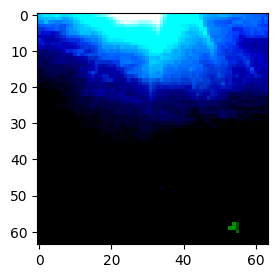

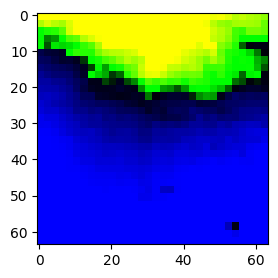

In [38]:

train_iter = iter(train_data)
img = next(train_iter)
imshow(img)

def init_conv(conv, out_r=1, in_r=1):
    o, i, h, w = conv.weight.shape
    conv_weight = torch.empty(o//out_r**2, i//in_r**2, h, w)
    nn.init.kaiming_uniform_(conv_weight)
    # conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat_interleave(in_r**2, dim=1))
    conv.weight.data.copy_(conv_weight.repeat_interleave(out_r**2, dim=0).repeat(1,in_r**2, 1,1))
    if conv.bias is not None: nn.init.zeros_(conv.bias)
    return conv


with torch.no_grad():
    # out = PixelShuffleConv(3, 3, kernel_size=1, r=1/2)(img)
    # out = nn.Conv2d(3, 3, kernel_size=1)(img)

    img = nn.PixelUnshuffle(2)(img)
    # img = nn.Conv2d(3*2**2, 3*1**2, 1, 1, padding=1//2)(img)
    img = init_conv(nn.Conv2d(3*2**2, 3//1**2, 1, 1, padding=1//2), out_r=1, in_r=2)(img)


    img = init_conv(nn.Conv2d(3*1**2, 3*2**2, 1, 1, padding=1//2), out_r=2, in_r=1)(img)
    # # img = nn.Conv2d(3*1**2, 3*2**2, 1, 1, padding=1//2)(img)
    img = nn.PixelShuffle(2)(img)

    # img = nn.Conv2d(12, 3, kernel_size=1)(img)
    # out = PixelShuffleConv(3, 3, kernel_size=1, r=2)(img)

    imshow(img)


In [ ]:
# @title autoencoder down

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_list=[64, 512, 4096]
        # r_list=[(360,640), (240,426), (144,256)] # https://en.wikipedia.org/wiki/Low-definition_television
        self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1), # AdaptiveAvgPool2d AdaptiveMaxPool2d
            nn.Flatten(start_dim=1),
            # nn.Linear()
        )

        self.deconv = nn.Sequential( # 'nearest', 'linear', 'bilinear', 'bicubic', 'trilinear'. # https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1), nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    # def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



In [ ]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm
# https://pytorch.org/xla/release/2.3/index.html
# https://github.com/pytorch/xla

xm.xla_device()
device = "cuda" if torch.cuda.is_available() else "cpu"

xm.mark_step()
xm.optimizer_step(optimizer)


### trash

In [ ]:
# @title vit
# https://arxiv.org/pdf/2010.11929.pdf
import torch
import torch.nn as nn
from torchvision import models
# https://pytorch.org/vision/main/models/vision_transformer.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16
# model = models.vit_l_16(weights='DEFAULT') # small vit_b_16 vit_b_32 vit_l_16 vit_l_32 vit_h_14 big
# # VisionTransformer(image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim)
# num_ftrs = model.heads.head.in_features
# # num_ftrs = model.heads[-1].in_features
# model.heads = nn.Sequential(
#     # nn.Dropout(0.2),
#     nn.Linear(num_ftrs, 6, bias=False),
#     nn.Softmax(dim=1),
#     )


!pip install timm
# https://github.com/huggingface/pytorch-image-models/issues/908
import timm
# model = timm.create_model('vit_base_patch16_224', pretrained=True)
model = timm.create_model('vit_base_patch16_224', img_size=(400, 640), pretrained=True)
# [print(x) for x in timm.list_models('vit*',pretrained=True)]
# https://huggingface.co/google/vit-base-patch16-224
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
# vit_base_patch16_224 compile,no ckpt # patch_size=16, embed_dim=768, depth=12, num_heads=12
# vit_base_patch16_384
# vit_large_patch16_224 explodesgpu # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384 # patch_size=16, embed_dim=1024, depth=24, num_heads=16

# or fine tune huge
# vit_large_patch14_224 # patch_size=16, embed_dim=1024, depth=24, num_heads=16
# vit_large_patch16_384


num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_ftrs, 6, bias=False),
    nn.Softmax(dim=1),
    )
# model.set_grad_checkpointing()

# print(model.patch_embed.grid_size) # (25, 40)
# print(model.pos_embed.shape) # [1, 1001, 768]
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

# print(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
model = torch.compile(model.to(device))
# model = torch.compile(model.to(device),mode='reduce-overhead')
# model = torch.compile(model.to(device),mode='max-autotune')

# vit_base_patch16_224 batch16 maxcompile nockpt gradacc lr1e-5,1e-4


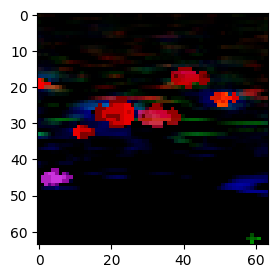

In [ ]:
imshow(state.detach().cpu()-out.detach().cpu())

In [ ]:
# @title autoencoder split

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        d_list=[64, 512, 4096]
        # r_list=[(360,640), (240,426), (144,256)] # https://en.wikipedia.org/wiki/Low-definition_television
        self.enc1 = nn.Sequential(nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(), nn.MaxPool2d(2, 2),)
        self.enc2 = nn.Sequential(nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(), nn.MaxPool2d(2, 2),)
        self.enc3 = nn.Sequential(nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.AdaptiveMaxPool2d(1), # AdaptiveAvgPool2d AdaptiveMaxPool2d
            nn.Flatten(start_dim=1),
            # nn.Linear()
        )

        # self.deconv1 = nn.Sequential(nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),)
        # self.deconv2 = nn.Sequential(nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),)
        # self.deconv3 = nn.Sequential(nn.Upsample(scale_factor=2), nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1), nn.Sigmoid(),)
        self.deconv1 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),)
        self.deconv2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),)
        self.deconv3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear'), nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1), nn.Sigmoid(),)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x[-1]

    def encode(self, x):
        x1=self.enc1(x)
        x2=self.enc2(x1)
        x3=self.enc3(x2)
        # return self.enc(x).squeeze()
        return x1,x2,x3
    def decode(self, x123):
        x1,x2,x3=x123
        x3=x3.unsqueeze(-1).unsqueeze(-1)
        o3=self.deconv3(self.deconv2(self.deconv1(x3)))
        o2=self.deconv3(self.deconv2(x2))
        o1=self.deconv3(x1)
        return o1,o2,o3
        # return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    # def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder().to(device)
# print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
# print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
# print(out.shape)
print([o.shape for o in out])
i2= model.decode(out)
# print(i2.shape)
print([i.shape for i in i2])



[torch.Size([4, 64, 16, 16]), torch.Size([4, 512, 4, 4]), torch.Size([4, 4096])]
[torch.Size([4, 3, 64, 64]), torch.Size([4, 3, 64, 64]), torch.Size([4, 3, 64, 64])]


torch.Size([3, 16, 16])


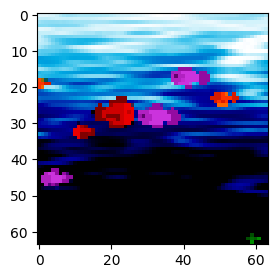

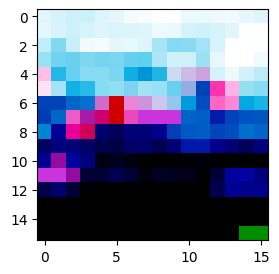

In [ ]:
epochs=30
# num_batches=len(train_loader)
# total_steps=int(num_batches*epochs)
# max_lr=1e-4
# min_lr=1e-7
# # max_lr* gamma^total_steps = min_lr
# gamma = np.exp(np.log(min_lr/max_lr)/total_steps)
# print(gamma)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=gamma) # 0.75(20)-0.9(100)
# train(train_loader,model,optim,scheduler)

state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
# print(state.shape)
pool = nn.AdaptiveMaxPool2d(16) # AdaptiveAvgPool2d AdaptiveMaxPool2d
# sx_ = model.encode(state.unsqueeze(0))
# # print(sx_.shape)
# out= model.decode(sx_.unsqueeze(0)).squeeze(0)
out = pool(state)

print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())



In [ ]:
# import torcheval
# from torcheval.metrics import StructuralSimilarity, FrechetInceptionDistance
# # https://pytorch.org/torcheval/main/torcheval.metrics.html#image-metrics
# loss_fn = torcheval.metrics.StructuralSimilarity()
# loss_fn = torcheval.metrics.FrechetInceptionDistance()
# from torchmetrics.image import StructuralSimilarityIndexMeasure # no backward
# from ignite.metrics import SSIM
# loss = SSIM(state_, state)
# loss = FrechetInceptionDistance(state_, state)